In [63]:
!pip install geopandas pandas
!pip install rasterio

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [65]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt


In [68]:
# 读取区域数据（假设是GeoJSON或Shapefile）
# 如果是GeoJSON或Shapefile文件，使用GeoPandas加载它
parks_file = '/content/drive/MyDrive/filtered_park_df.geojson'  # 替换为你文件的路径
parks_gdf = gpd.read_file(parks_file)

# 读取人口数据 (GeoTIFF 文件)
#population_gdf = gpd.read_file ( ) # 替换为实际路径
#raster = rasterio.open('/content/drive/MyDrive/.tif')
population_tif = '/content/drive/MyDrive/Shanghai_Population_Elder_Middle_Ring.tif'  # 替换为实际路径
raster = rasterio.open(population_tif)

# 查看栅格数据的信息
print(raster.meta)

# 检查公园数据
#print(parks_gdf.head())




{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 278, 'height': 201, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008983152841195215, 0.0, 121.37137803738855,
       0.0, -0.0008983152841195215, 31.31347417383828)}


In [69]:
# 将公园数据转换为投影坐标系（以米为单位，方便创建缓冲区）
parks_gdf = parks_gdf.to_crs(epsg=32650)

# 创建 500 米缓冲区
parks_gdf['buffer_500m'] = parks_gdf.geometry.buffer(500)

# 查看缓冲区
print(parks_gdf[['OBJECTID', 'buffer_500m']].head())
parks_gdf

   OBJECTID                                        buffer_500m
0        56  POLYGON ((925222.541 3463675.315, 925194.945 3...
1        57  POLYGON ((925016.489 3463008.109, 925019.003 3...
2       129  POLYGON ((926191.195 3464576.43, 926167.951 34...
3       246  POLYGON ((927003.041 3459717.862, 926885.647 3...
4       247  POLYGON ((927118.956 3459730.665, 927091.426 3...


,OBJECTID,osm_id,code,fclass,name,Shape_Leng,Shape_Area,geometry,buffer_500m
0,56,39763744,7202,park,人民公园,0.013504,9.854620e-06,"MULTIPOLYGON (((925966.322 3464215.256, 926008...","POLYGON ((925222.541 3463675.315, 925194.945 3..."
1,57,39961770,7202,park,复兴公园,0.011324,6.920550e-06,"MULTIPOLYGON (((925432.001 3462632.445, 925439...","POLYGON ((925016.489 3463008.109, 925019.003 3..."
2,129,50258395,7202,park,大观园绿地,0.004629,9.350000e-07,"MULTIPOLYGON (((925735.847 3464782.966, 925621...","POLYGON ((926191.195 3464576.43, 926167.951 34..."
3,246,58413664,7202,park,None,0.004009,4.514200e-07,"MULTIPOLYGON (((926958.678 3460215.929, 926835...","POLYGON ((927003.041 3459717.862, 926885.647 3..."
4,247,58413720,7202,park,None,0.005192,9.922400e-07,"MULTIPOLYGON (((927060.441 3460227.229, 927048...","POLYGON ((927118.956 3459730.665, 927091.426 3..."
...,...,...,...,...,...,...,...,...,...
105,5513,477138725,7202,park,None,0.001543,1.101900e-07,"MULTIPOLYGON (((923840.196 3461519.881, 923818...","POLYGON ((923652.836 3461983.449, 923700.088 3..."
106,5514,477138726,7202,park,None,0.001404,1.157900e-07,"MULTIPOLYGON (((923472.148 3461469.703, 923444...","POLYGON ((923925.525 3461680.531, 923944.156 3..."
107,6469,571607270,7202,park,None,0.002431,2.940200e-07,"MULTIPOLYGON (((923777.762 3460153.043, 923818...","POLYGON ((923267.38 3460256.369, 923271.094 34..."
108,9370,870546902,7202,park,None,0.008064,1.239510e-06,"MULTIPOLYGON (((924973.594 3457760.709, 924975...","POLYGON ((924466.422 3457583.043, 924465.81 34..."


In [70]:
import rasterio

raster = rasterio.open(population_tif)

# 检查坐标系
print("Raster CRS:", raster.crs)



Raster CRS: EPSG:4326


In [71]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# 打开原始栅格文件
with rasterio.open(population_tif) as src:
    # 检查原始栅格的 CRS
    print("Original Raster CRS:", src.crs)

    # 目标 CRS 为 EPSG:32650
    target_crs = 'EPSG:32650'

    # 计算目标 CRS 的转换
    transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

    # 创建新的栅格文件，存储转换后的数据
    with rasterio.open('/content/drive/MyDrive/population_tif_32650.tif', 'w', driver='GTiff',
                       height=height, width=width, count=src.count, dtype=src.dtypes[0],
                       crs=target_crs, transform=transform) as dst:
        # 进行 CRS 转换并重新投影
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )




Original Raster CRS: EPSG:4326


In [72]:
raster=rasterio.open('/content/drive/MyDrive/population_tif_32650.tif')

In [73]:
population_density = []  # 存储结果

for idx, row in parks_gdf.iterrows():
    buffer_geom = [mapping(row['buffer_500m'])]  # 获取缓冲区几何

    try:
        # 裁剪栅格到缓冲区范围
        out_image, out_transform = mask(raster, buffer_geom, crop=True)

        # 获取有效人口像素值 (过滤掉无效值，如 nodata)
        out_image = out_image[0]  # 读取第一个波段
        valid_pixels = out_image[out_image > 0]  # 过滤无效值

        # 总人口
        total_population = valid_pixels.sum()

        # 计算缓冲区的面积 (单位与栅格分辨率一致，如平方米)
        pixel_area = raster.res[0] * raster.res[1]  # 每个像素的面积
        buffer_area = pixel_area * len(valid_pixels)  # 有效像素总面积

        # 人口密度
        density = total_population / (buffer_area / 1e6)  # 转换为每平方公里

        # 保存结果
        population_density.append({
            'OBJECTID': row['OBJECTID'],  # 缓冲区名称
            'total_population': total_population,
            'buffer_area_km2': buffer_area / 1e6,
            'population_density': density
        })

    except ValueError as e:
        print(f"Error processing buffer for {row['OBJECTID']} at index {idx}: {e}")
        population_density.append({
            'OBJECTID': row['OBJECTID'],
            'total_population': 0,
            'buffer_area_km2': 0,
            'population_density': 0
        })

# 转换结果为 DataFrame
import pandas as pd
density_df = pd.DataFrame(population_density)

# 查看结果
print(density_df)


     OBJECTID  total_population  buffer_area_km2  population_density
0          56       6774.360716         1.566975         4323.209232
1          57       9147.517380         1.410277         6486.324482
2         129       4117.828101         0.948432         4341.720982
3         246       7472.023555         0.997916         7487.630415
4         247       7407.010480         1.030905         7184.962137
..        ...               ...              ...                 ...
105      5513       3149.824916         0.865960         3637.379818
106      5514       3729.218042         0.865960         4306.456010
107      6469       5060.684915         0.915443         5528.125035
108      9370       6991.552846         0.676273        10338.352359
109     10340       5821.562156         0.898949         6475.966277

[110 rows x 4 columns]


In [74]:
# 合并结果到缓冲区数据
buffer_gdf = parks_gdf.merge(density_df, on='OBJECTID', how='left')

# 查看合并后的数据
print(buffer_gdf[['OBJECTID', 'total_population', 'buffer_area_km2', 'population_density']])


     OBJECTID  total_population  buffer_area_km2  population_density
0          56       6774.360716         1.566975         4323.209232
1          57       9147.517380         1.410277         6486.324482
2         129       4117.828101         0.948432         4341.720982
3         246       7472.023555         0.997916         7487.630415
4         247       7407.010480         1.030905         7184.962137
..        ...               ...              ...                 ...
105      5513       3149.824916         0.865960         3637.379818
106      5514       3729.218042         0.865960         4306.456010
107      6469       5060.684915         0.915443         5528.125035
108      9370       6991.552846         0.676273        10338.352359
109     10340       5821.562156         0.898949         6475.966277

[110 rows x 4 columns]


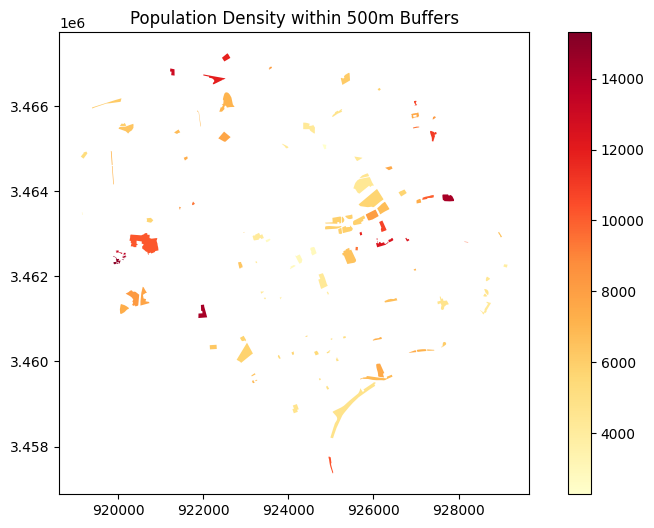

In [75]:
import matplotlib.pyplot as plt

# 绘制人口密度地图
buffer_gdf.plot(column='population_density', cmap='YlOrRd', legend=True, figsize=(10, 6))
plt.title('Population Density within 500m Buffers')
plt.show()


In [76]:
buffer_gdf[['OBJECTID', 'population_density']].to_csv('/content/drive/MyDrive/pop_density.csv', index=False)

print("CSV file has been saved.")

CSV file has been saved.
